## Imports

In [1]:
%env CUDA_VISIBLE_DEVICES=1
%matplotlib inline

env: CUDA_VISIBLE_DEVICES=1


In [3]:
import os                                                                       
import numpy as np                                                              
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tensorflow as tf                                                         
import data.data_selector as ds                                                   
import utils.data_processing as dp
import utils.plot_functions as pf                                               
import analysis.analysis_picker as ap

In [6]:
analysis_params = {
  "model_type": "ica",
  "model_name": "ica",
  "version": "1.0"}

# Computed params
analysis_params["model_dir"] = (os.path.expanduser("~")+"/Work/Projects/"+analysis_params["model_name"])

In [8]:
analyzer = ap.get_analyzer(analysis_params)
analyzer.model.setup(analyzer.model_params, analyzer.model_schedule)
analyzer.load_analysis(save_info="full_imgs")

ot_bf_indices = analyzer.ot_grating_responses["neuron_indices"]
ot_contrasts = analyzer.ot_grating_responses["contrasts"]
ot_phases = analyzer.ot_grating_responses["phases"]
ot_orientations = analyzer.ot_grating_responses["orientations"]
ot_best_phases = analyzer.ot_grating_responses["best_phases"]
ot_mean_activations = analyzer.ot_grating_responses["mean_responses"]

co_bf_indices = analyzer.co_grating_responses["neuron_indices"]
co_contrasts = analyzer.co_grating_responses["contrasts"]
co_phases = analyzer.co_grating_responses["phases"]
co_base_orientations = analyzer.co_grating_responses["base_orientations"]
co_mask_orientations = analyzer.co_grating_responses["mask_orientations"]
co_base_mean_responses = analyzer.co_grating_responses["base_mean_responses"]
co_test_mean_responses = analyzer.co_grating_responses["test_mean_responses"]

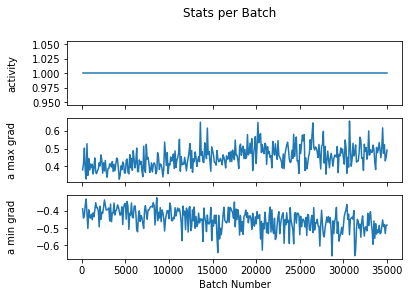

In [9]:
stats_fig = pf.plot_stats(analyzer.run_stats,
  keys=["u_fraction_active", "a_max_grad", "a_min_grad"],
  labels=["activity", "a max grad", "a min grad"])

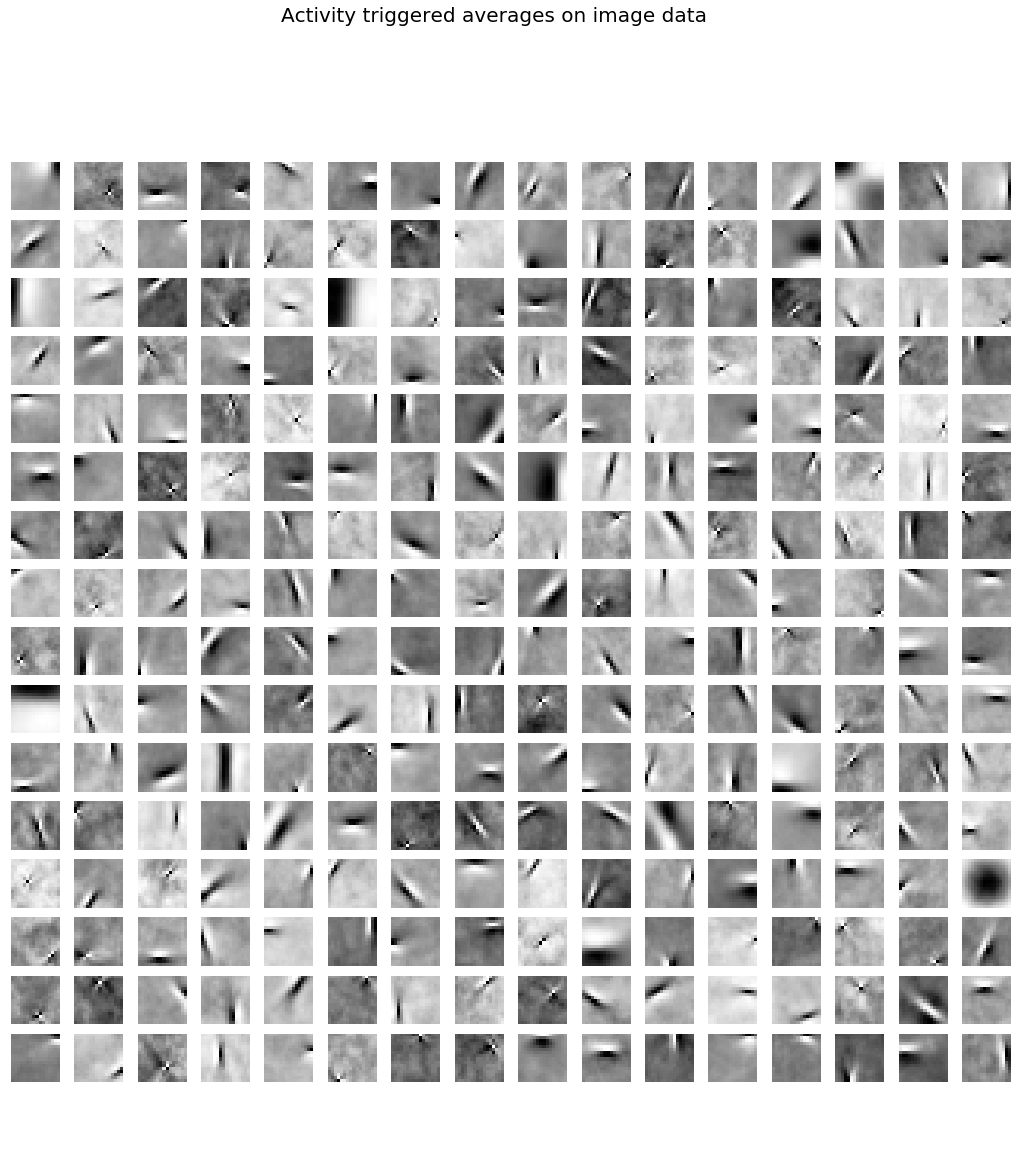

In [10]:
atas_fig = pf.plot_weights(analyzer.atas.T.reshape(256,16,16), title="Activity triggered averages on image data")

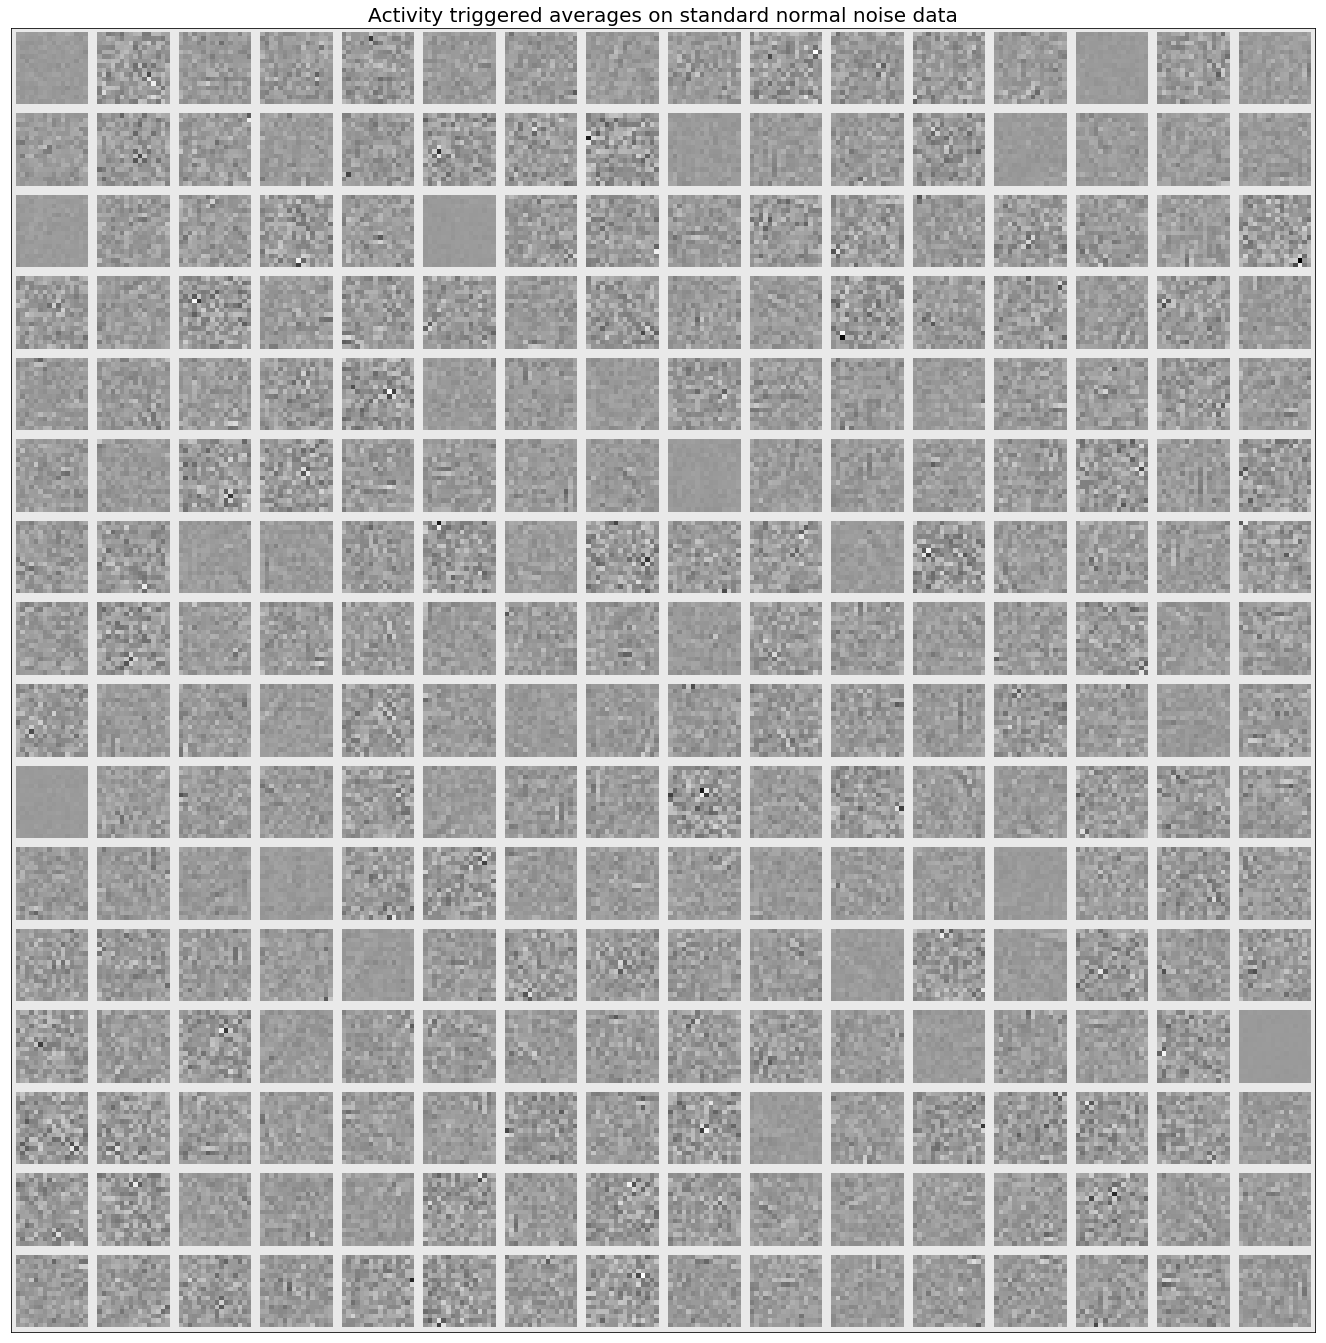

In [11]:
noise_images = np.random.standard_normal([analyzer.model_params["num_images"]]+analyzer.model_params["data_shape"])
noise_evals = analyzer.evaluate_model(noise_images, ["inference/coefficients:0"])
noise_atas = analyzer.compute_atas(noise_evals["inference/coefficients:0"], noise_images)
noise_atas_fig = pf.plot_data_tiled(noise_atas.T, normalize=False, title="Activity triggered averages on standard normal noise data")
noise_atas_fig.savefig(analyzer.analysis_out_dir+analysis_params["model_name"]+"_noise_atas.png")

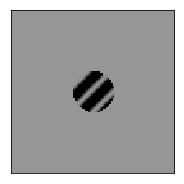

In [12]:
grating = dp.generate_grating(rf_edge=100, location=(50,50), diameter=25,
  orientation=np.pi/4, frequency=10, phase=4*np.pi/6, contrast=0.5)
fig, ax = plt.subplots(1, figsize=(3, 3))
ax = pf.clear_axis(ax, spines="k")
ax.imshow(grating, cmap="Greys_r", vmin=0, vmax=1)
plt.show()

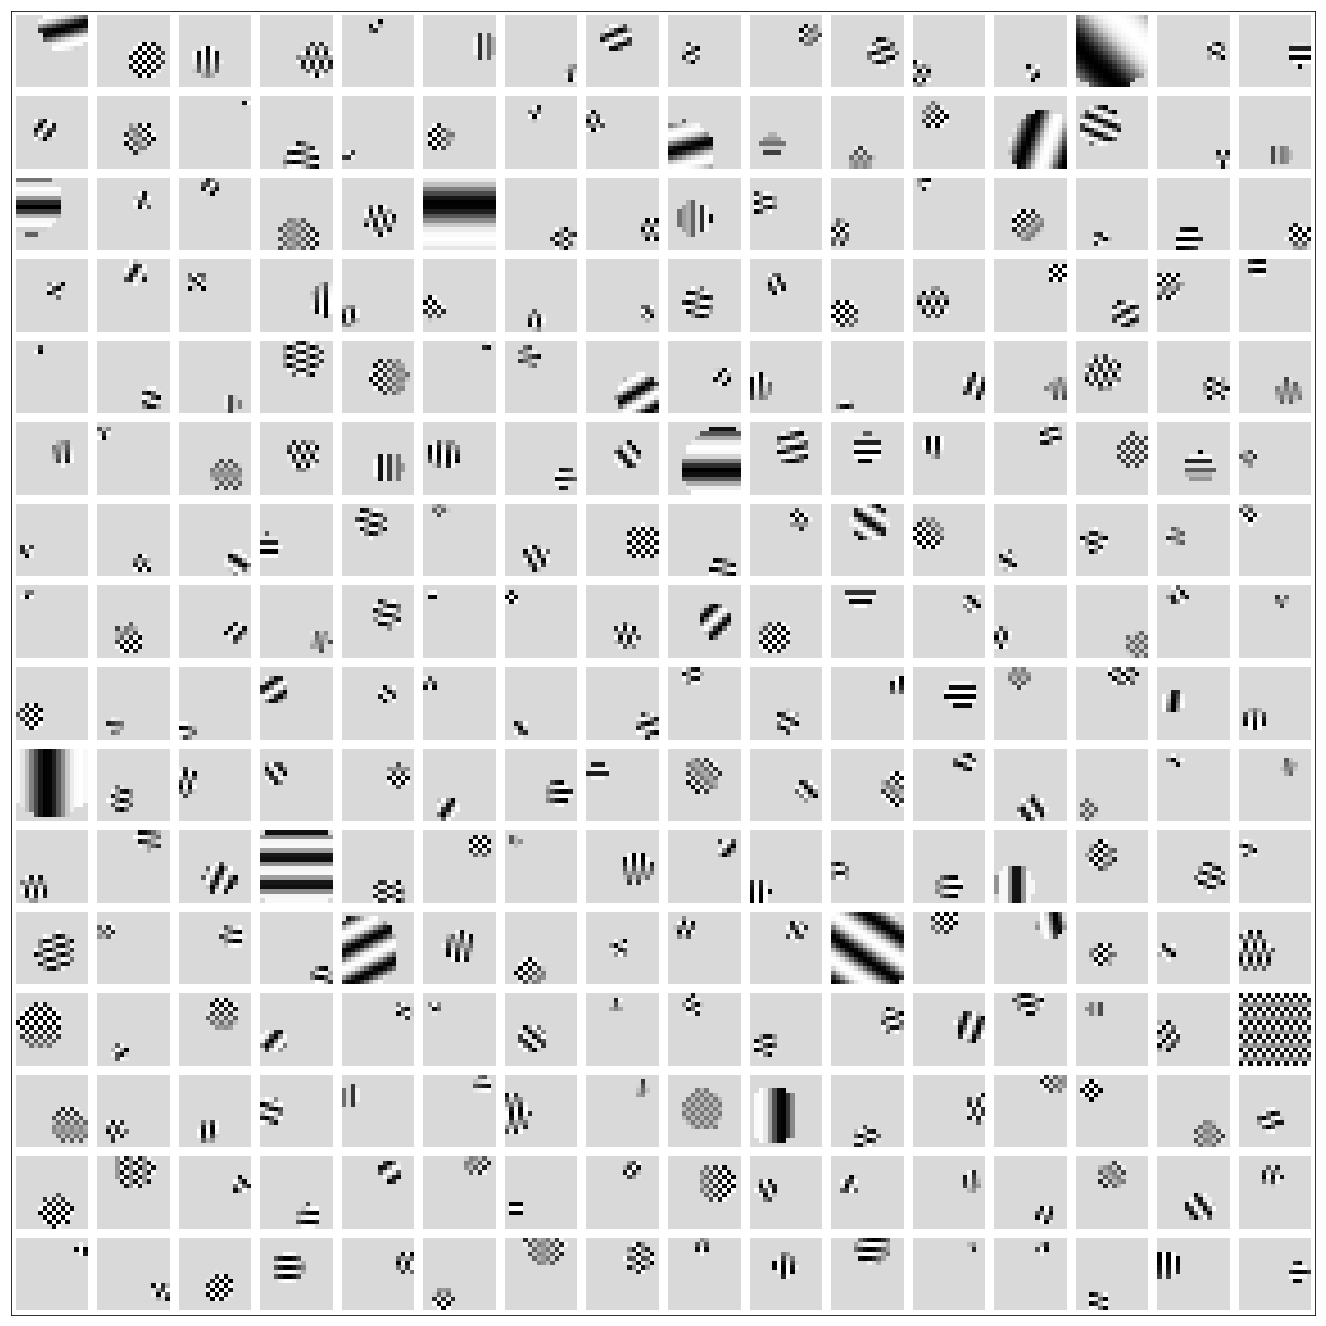

In [14]:
constructed_bfs = np.zeros_like(analyzer.evals["weights/a_inverse:0"])
for bf_idx in range(constructed_bfs.shape[0]):
  params = dp.get_grating_params(analyzer.bf_stats, bf_idx)
  grating = dp.generate_grating(*params)
  constructed_bfs[bf_idx,...] = grating.reshape(256)
fig = pf.plot_data_tiled(constructed_bfs)

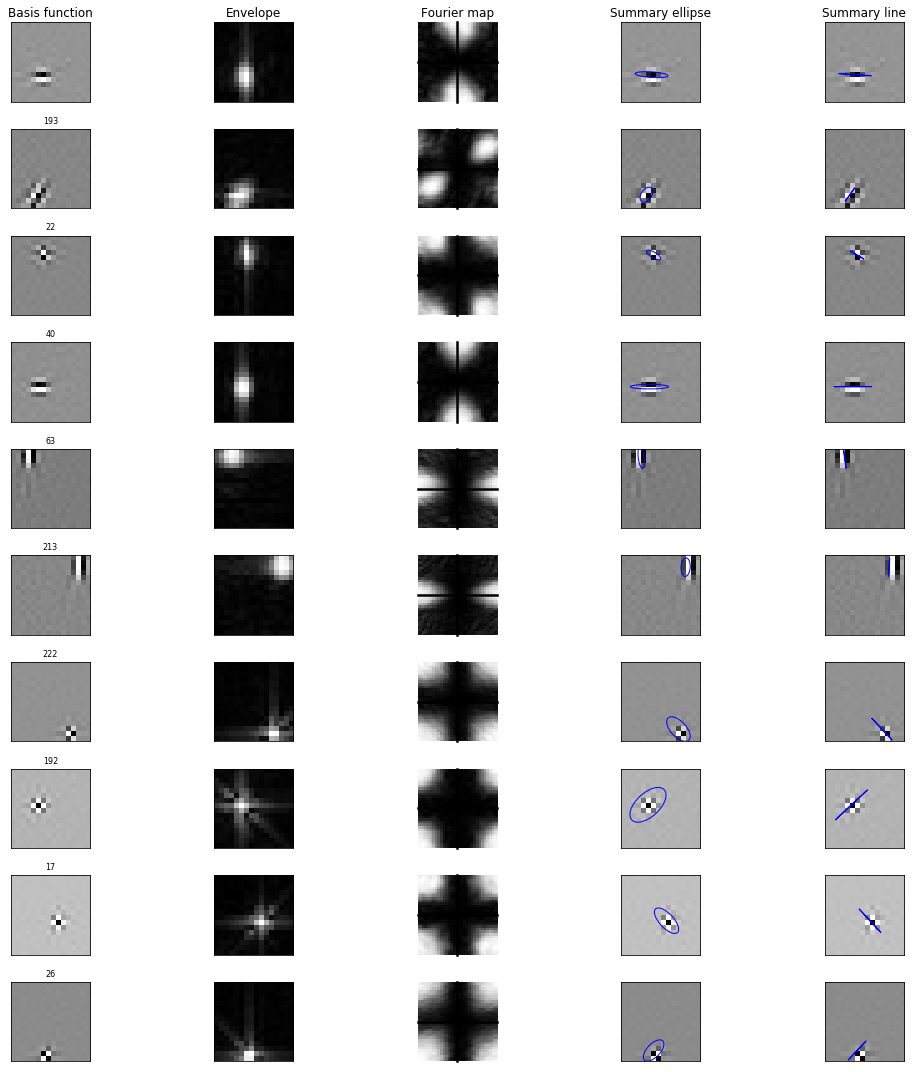

In [15]:
fig = pf.plot_bf_stats(analyzer.bf_stats, num_bf=10)

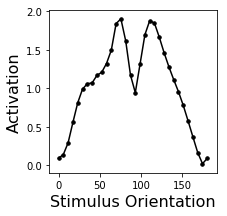

In [18]:
8f_idx = 0
cmap = plt.get_cmap('Greys')
cNorm = matplotlib.colors.Normalize(vmin=0.0, vmax=1.0)
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=cmap)

fig, ax = plt.subplots(1, figsize=(3,3))
ax.set_ylabel("Activation", fontsize=16)
ax.set_xlabel("Stimulus Orientation", fontsize=16)
#for co_idx, contrast in enumerate(ot_contrasts):
co_idx = -1
contrast = ot_contrasts[co_idx]
activity = ot_mean_activations[bf_idx,co_idx,:]# / np.max(ot_contrast_activations)
color_val = scalarMap.to_rgba(1.0)#contrast)
ax.plot(np.asarray(ot_orientations)*(180/np.pi), activity, color=color_val)
ax.scatter(np.asarray(ot_orientations)*(180/np.pi), activity, s=12, c=color_val)
plt.show()

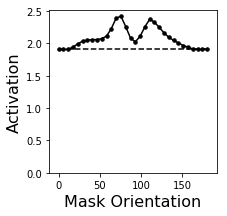

In [32]:
num_orientations = np.asarray(co_mask_orientations).size
cmap = plt.get_cmap('Greys')
cNorm = matplotlib.colors.Normalize(vmin=0.0, vmax=1.0)
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=cmap)

fig, ax = plt.subplots(1, figsize=(3,3))
ax.set_ylabel("Activation", fontsize=16)
ax.set_xlabel("Mask Orientation", fontsize=16)
bco_idx = -1
co_idx = -1
contrast = co_contrasts[bco_idx]
base_activity = co_base_mean_responses[0, bco_idx]
test_activity  = co_test_mean_responses[0, bco_idx, co_idx, :]
ax.set_ylim([0.0, np.max(np.stack([[base_activity,]*num_orientations, test_activity]))+0.1])
color_val = scalarMap.to_rgba(1.0)
ax.plot(np.asarray(co_mask_orientations)*(180/np.pi), [base_activity,]*num_orientations, linestyle="--", color=color_val)
ax.plot(np.asarray(co_mask_orientations)*(180/np.pi), test_activity, linestyle="-", color=color_val)
ax.scatter(np.asarray(co_mask_orientations)*(180/np.pi), test_activity, s=12, c=color_val)
plt.show()

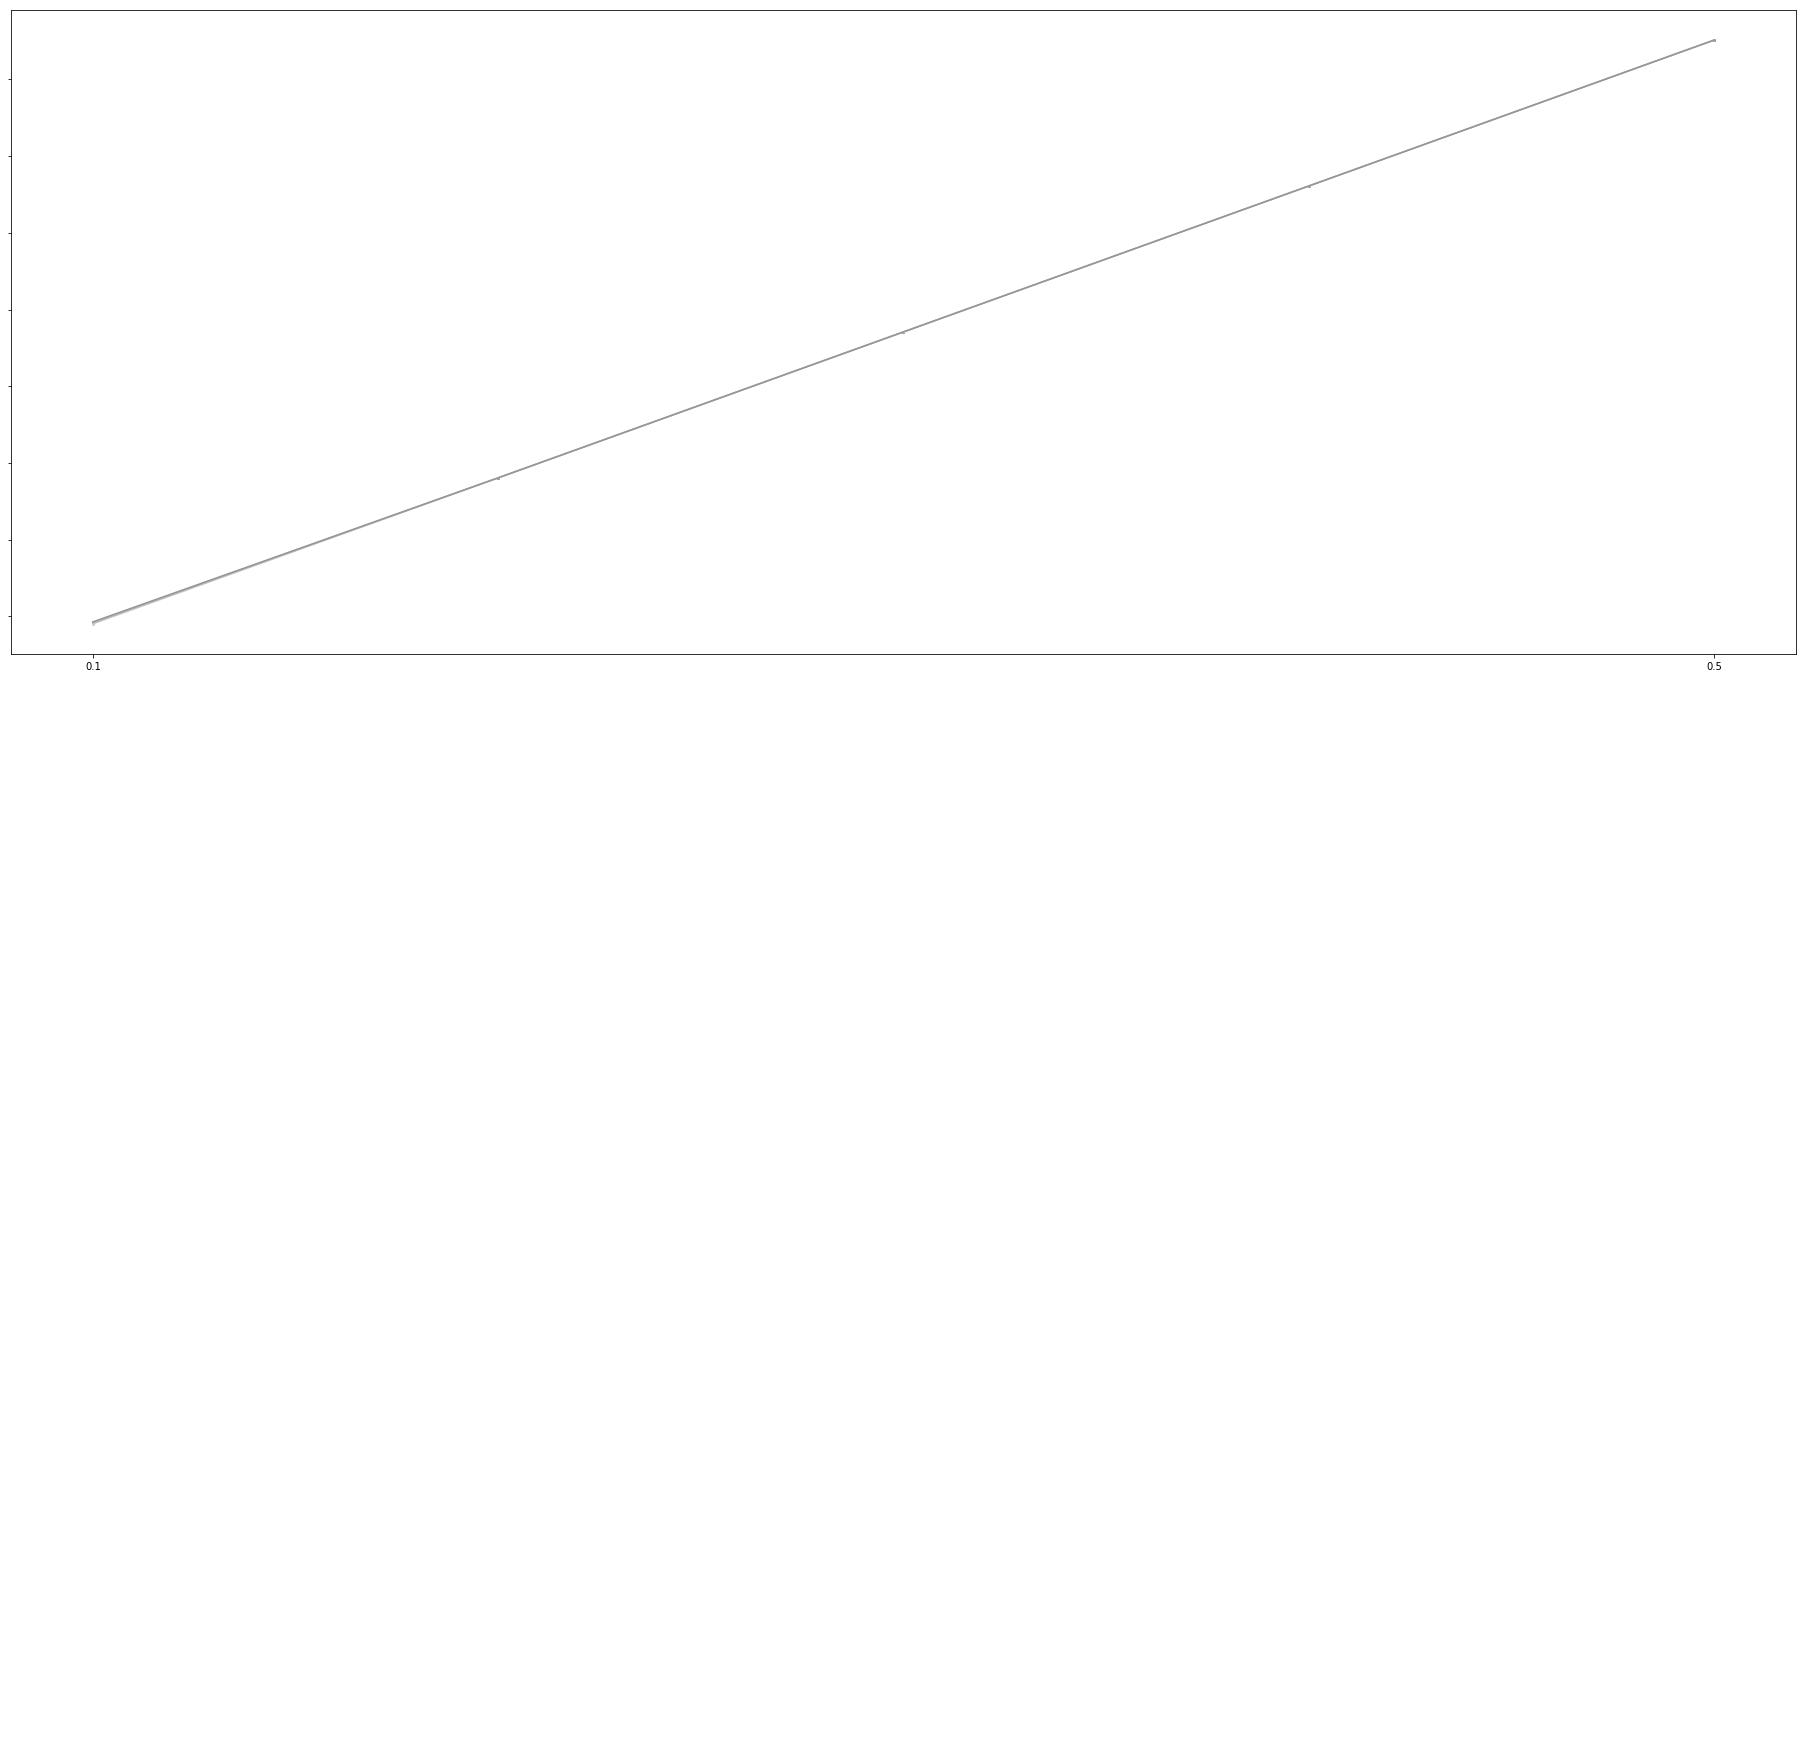

In [34]:
#num_orientations = np.asarray(co_mask_orientations).size
#num_contrasts = np.asarray(co_contrasts).size
## index of value in mask_orientations that is closest to orthogonal to base_orientations[bf_idx]
#orthogonal_orientation = co_base_orientations[0]-(np.pi/2)
#if orthogonal_orientation < 0:
#  orthogonal_orientation += np.pi
#mask_or_idx = np.argmin(orthogonal_orientation - mask_orientations)
#max_test_responses = np.max(co_test_responses)
#
#cmap = plt.get_cmap('Greys')
##cNorm = matplotlib.colors.Normalize(vmin=0.0, vmax=1.0)
#cNorm = matplotlib.colors.SymLogNorm(linthresh=0.03, linscale=0.01, vmin=0.0, vmax=1.0)
#scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=cmap)
#
#fig, ax = plt.subplots(1, figsize=(13,13))
##ax.set_ylabel("Activation", fontsize=16)
##ax.set_xlabel("Base Contrast", fontsize=16)
#ax.set_ylim([0.0, 0.65])
#for co_idx, mask_contrast in enumerate(contrasts):
#  # vary base contrast for fixed mask contrast & orthogonal mask
#  activity  = co_test_responses[0, :, co_idx, mask_or_idx]
#  #activity /= max_test_responses
#  color_val = scalarMap.to_rgba(mask_contrast)
#  ax.plot(contrasts, activity, linestyle="-", color=color_val, label="{:.1f}".format(mask_contrast))
#  ax.scatter(contrasts, activity, s=30, c=color_val)
#  ax.set_xscale('log')
#  #ax.tick_params(
#  #  axis='x',          # changes apply to the x-axis
#  #  which='both',      # both major and minor ticks are affected
#  #  labelbottom='off')
#  #ax.set_xticks(contrasts)
#  #ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#  #ax.get_xaxis().get_major_formatter().set_scientific(False)
#  #ax.set_xticklabels([str(contrast) for contrast in contrasts])
#  #ax.set_xticklabels(["" for contrast in contrasts])
#  #ax.ticklabel_format(style="plain")
#ax.legend(title="Mask Contrast")
#plt.show()
fig = pf.plot_plaid_contrast_tuning([0], co_contrasts, co_contrasts, co_base_orientations, co_mask_orientations,
  co_test_mean_responses)

In [ ]:
#grating = lambda orientation,phase,contrast:dp.generate_grating(*dp.get_grating_params(analyzer.bf_stats, bf_idx,
#  orientation=orientation, phase=phase, contrast=contrast, diameter=-1))
##def plot_phase_orientation_responses(bf_idx, contrast_idx, analyzer):
#bf_idx = 40#120
#contrast_idx = -1
#peak_orientation_idx = np.argmax(contrast_activations[bf_idx, contrast_idx])
#fig = plt.figure()
#gs_widths = [1, 1]
#gs_heights = [1, 1]
#gs = gridspec.GridSpec(2, 2, wspace=0.6, hspace=0.8, width_ratios=gs_widths, height_ratios=gs_heights)
#
#ax = plt.subplot(gs[0,0])
#ax.bar(phases, phase_activations[bf_idx, contrast_idx, peak_orientation_idx, :], width=0.3)
#ax.set_xlabel("Phase (Radians)")
#ax.set_ylabel("Activation")
#
#ax = plt.subplot(gs[0,1])
#ax.bar(orientations, contrast_activations[bf_idx, contrast_idx], width=0.3)
#ax.set_xlabel("Orientation (Radians)")
#ax.set_ylabel("Normalized\nActivation")
#
#ax = pf.clear_axis(plt.subplot(gs[1,0]))
#ax.imshow(analyzer.bf_stats["basis_functions"][bf_idx], cmap="Greys_r")
#
#best_phase = best_phases[bf_idx, contrast_idx, peak_orientation_idx]
#stim = grating(orientations[peak_orientation_idx], best_phase, contrast=1.0)
#ax = pf.clear_axis(plt.subplot(gs[1,1]))
#ax.imshow(stim, cmap="Greys_r")
#plt.show()

In [ ]:
#finite_widths = half_widths[np.isfinite(half_widths)]
#if np.sum(int(np.isfinite(half_widths[bf_idx,:]))) > 1:
#  slope = (np.max(finite_widths[bf_idx,:]) - np.min(finite_widths[bf_idx,:]))/(np.max(contrasts) - np.min(contrasts))
#  fig, ax = plt.subplots(1)
#  ax.plot(contrasts, finite_widths[bf_idx,:])
#  ax.set_ylim([0,np.max(finite_widths[bf_idx,:])+0.1])
#  ax.text(0.4,1.0, "Slope="+"{:.3f}".format(slope))
#  ax.set_xlabel("Contrast", fontsize=16)
#  ax.set_ylabel("Half Width", fontsize=16)
#  plt.show()

In [ ]:
#from scipy.optimize import curve_fit
#
#def gauss(x, *p):
#  A, mu, sigma = p
#  return A*np.exp(-(x-mu)**2/(2*sigma**2))
#
#contrast_idx = 2
#
#half_activity = contrast_activations[contrast_idx][19:51]
#half_orientations = orientations[19:51]
#half_activity /= np.max(contrast_activations)
#
#a0 = np.max(half_activity)
#mu0 = half_orientations[np.argmax(half_activity)]
#sig0 = np.std(half_activity[half_activity>0])
#p0 = [a0, mu0, sig0] # initial guess
#coeff, var_matrix = curve_fit(gauss, half_orientations, half_activity, p0=p0)
#
#half_max = coeff[0]/2
#half_width = 2*np.sqrt(2*np.log(2))*coeff[2]
#
### Outputs
#print("Max activation = ", np.max(half_activity[half_activity>0]))
#print("Mean activation = ", np.mean(half_activity[half_activity>0]))
#print("Std activation = ", np.std(half_activity[half_activity>0]))
#print("A0 = ", a0)
#print("mu0 = ", mu0)
#print("sig0 = ", sig0)
#print("Fitted amplitude = ", coeff[0])
#print("Fitted mean = ", coeff[1])
#print("Fitted standard deviation = ", coeff[2])
#print("Half max = ", half_max)
#print("FWHM = ", half_width)
#
#hist_fit = gauss(half_orientations, *coeff)# Get the fitted curve
#fig, ax = plt.subplots(1)
#ax.scatter(half_orientations, half_activity, label="Test data")
#ax.plot(half_orientations, hist_fit, c='r', label="Fitted data")
#ax.plot(half_orientations, [half_max,]*len(half_orientations), 'k--', label="FWHM")
#ax.legend()
#plt.show()

In [10]:
#num_bfs = 9
#num_orientations = np.asarray(mask_orientations).size
#cmap = plt.get_cmap('Greys')
#cNorm = matplotlib.colors.Normalize(vmin=0.0, vmax=1.0)
#scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=cmap)
#
#fig = plt.figure(figsize=(18,18))
#num_plots_y = np.int32(np.ceil(np.sqrt(num_bfs)))+1
#num_plots_x = np.int32(np.ceil(np.sqrt(num_bfs)))
#gs_widths = [1.0,]*num_plots_x
#gs_heights = [1.0,]*num_plots_y
#gs = gridspec.GridSpec(num_plots_y, num_plots_x, wspace=0.5, hspace=0.7, width_ratios=gs_widths, height_ratios=gs_heights)
#bf_idx = 0
#for plot_id in np.ndindex((num_plots_y, num_plots_x)):
#  (y_id, x_id) = plot_id
#  if y_id == 0 and x_id == 0:
#    ax = fig.add_subplot(gs[plot_id])
#    ax.set_ylabel("Normalized Activation", fontsize=16)
#    ax.set_ylim([0.0, np.max(co_test_responses)])
#    ax00 = ax
#  else:
#    ax = fig.add_subplot(gs[plot_id], sharey=ax00)
#  if bf_idx < num_bfs:
#    bco_idx = -1
#    co_idx = -1
#    contrast = contrasts[bco_idx]
#    base_activity = co_base_responses[bf_idx, bco_idx]
#    masked_activity  = co_test_responses[bf_idx, bco_idx, co_idx, :]
#    color_val = scalarMap.to_rgba(1.0)#contrast)
#    ax.plot(mask_orientations*(180/np.pi), [base_activity,]*num_orientations, linestyle="--", color=color_val)
#    ax.plot(mask_orientations*(180/np.pi), masked_activity, linestyle="-", color=color_val)
#    ax.scatter(mask_orientations*(180/np.pi), masked_activity, s=12, c=color_val)
#    bf_idx += 1
#  else:
#    ax = pf.clear_axis(ax, spines="none")
#plt.show()

In [ ]:
#num_bfs = 9
#num_orientations = np.asarray(mask_orientations).size
#num_contrasts = np.asarray(contrasts).size
#base_or_idx = [np.argmax(co_test_responses[bf_idx,-1,-1,:])
#  for bf_idx in range(analyzer.bf_stats["num_outputs"])]
#
#cmap = plt.get_cmap('Greys')
#cNorm = matplotlib.colors.Normalize(vmin=0.0, vmax=1.0)
#scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=cmap)
#
#fig = plt.figure(figsize=(18,18))
#num_plots_y = np.int32(np.ceil(np.sqrt(num_bfs)))+1
#num_plots_x = np.int32(np.ceil(np.sqrt(num_bfs)))
#gs_widths = [1.0,]*num_plots_x
#gs_heights = [1.0,]*num_plots_y
#gs = gridspec.GridSpec(num_plots_y, num_plots_x, wspace=0.5, hspace=0.7, width_ratios=gs_widths, height_ratios=gs_heights)
#bf_idx = 0
#for plot_id in np.ndindex((num_plots_y, num_plots_x)):
#  (y_id, x_id) = plot_id
#  if y_id == 0 and x_id == 0:
#    ax = fig.add_subplot(gs[plot_id])
#    ax.set_ylabel("Normalized Activation", fontsize=16)
#    ax.set_xlabel("Test Contrast")
#    ax.set_ylim([0.0, np.max(co_test_responses)])
#    ax00 = ax
#  else:
#    ax = fig.add_subplot(gs[plot_id], sharey=ax00)
#  if bf_idx < num_bfs:
#    for co_idx, test_contrast in enumerate(contrasts):
#      test_activity  = co_test_responses[bf_idx, :, co_idx, base_or_idx[bf_idx]]
#      color_val = scalarMap.to_rgba(test_contrast)
#      ax.plot(contrasts, test_activity, linestyle="-", color=color_val)
#      ax.scatter(contrasts, test_activity, s=12, c=color_val, label=str(test_contrast))
#    bf_idx += 1
#  else:
#    ax = pf.clear_axis(ax, spines="none")
#
#  ax00.legend()
#plt.show()